# Data Understanding

Data Understanding adalah tahapan awal dalam proses pembangunan sistem berbasis data (seperti sistem rekomendasi, machine learning, atau data analytics) yang bertujuan untuk:

Memahami struktur, isi, dan kualitas data yang tersedia sebelum dilakukan analisis atau modeling.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

1. Membaca dataset

In [ ]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

2. Melihat bentuk dan informasi umum

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Dataset ini berisi informasi tentang berbagai anime dengan beberapa fitur, yaitu:

anime_id: Identifikasi unik untuk setiap anime.

name: Nama anime.

genre: Kategori atau jenis cerita anime, yang dapat mencakup beberapa genre seperti Drama, Romance, Action, Adventure, dll.

type: Tipe anime, seperti TV atau Movie.

episodes: Jumlah episode anime (untuk tipe TV) atau durasi film (untuk tipe Movie).

rating: Rating yang diberikan oleh pengguna, menggambarkan penilaian umum terhadap anime.

members: Jumlah anggota yang terdaftar atau pengikut anime tersebut di platform.

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
missing_rows = anime[anime.isnull().any(axis=1)]
missing_rows

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,NaN,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


Hasil ouput diatas menunjukan bahwa dataset ini mengandung masalah seperyi missing values dan tipe data data yang tidak sesuai.


In [ ]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Terlihat bahwa semua nilai rating bernilai -1.0. Dalam banyak dataset sistem rekomendasi (terutama dari MyAnimeList atau yang sejenis), nilai -1.0 biasanya digunakan untuk menandakan bahwa pengguna belum memberikan rating. Maka, data dengan rating -1.0 perlu dihapus, karena bisa merusak kualitas prediksi.

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [ ]:
missing_rows = rating[rating.isnull().any(axis=1)]
missing_rows

,user_id,anime_id,rating


Dataset ini berisi 1.607.823 baris, dan setiap baris mewakili seorang user (user_id) memberikan rating ke sebuah anime (anime_id). Kolom rating hanya memiliki 1607.822 nilai non-null, artinya ada data yang missing (hilang)

3. Mengecek nilai unik

In [ ]:
print("Jenis tipe anime:", anime['type'].unique())
print("Jumlah user unik:", rating['user_id'].nunique())
print("Jumlah anime unik (di rating):", rating['anime_id'].nunique())

Jenis tipe anime: ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA' nan]
Jumlah user unik: 73515
Jumlah anime unik (di rating): 11200


Ini adalah daftar kategori atau jenis anime yang terdapat di dataset.

Artinya, anime-anime yang ada bisa berupa:

* 'Movie' : Film anime (biasanya tayang di bioskop).

* 'TV' : Serial anime yang ditayangkan di TV.

* 'OVA' : Original Video Animation (langsung dirilis ke DVD/Bluray, bukan tayang di TV).

* 'Special' : Episode spesial, biasanya bonus.

* 'Music' : Klip musik atau konser anime.

* 'ONA' : Original Net Animation (dirilis secara eksklusif online).

* nan : Terdapat missing values pada kolom type (jenis anime tidak diketahui).

4. Mengecek duplikasi

In [ ]:
print("Duplikat di anime:", anime.duplicated().sum())
print("Duplikat di rating:", rating.duplicated().sum())

Duplikat di anime: 0
Duplikat di rating: 1


Dapat dilihat bahwa data anime bersih dari duplikat, tetapi data pada rating memilik data yang terduplikat.

5. Melihat statistik deskriptif numerik

In [ ]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Berdasarkan hasil analisis deskriptif pada dataset anime, dapat disimpulkan bahwa data terdiri dari 12.294 entri dengan tiga kolom numerik utama, yaitu anime_id, rating, dan members. Kolom rating memiliki 230 nilai yang hilang, yang perlu ditangani pada tahap preprocessing. Rata-rata rating anime cukup tinggi yaitu 6.47 dengan nilai maksimum 10 dan minimum 1.67, menunjukkan bahwa sebagian besar anime dinilai cukup baik oleh pengguna. Kolom members, yang merepresentasikan jumlah pengguna yang menambahkan anime ke daftar mereka, menunjukkan distribusi yang sangat tidak merata, dengan rata-rata sekitar 18.000 dan maksimum lebih dari satu juta, menandakan adanya beberapa anime yang sangat populer dibandingkan lainnya. Sementara anime_id hanya merupakan identitas unik dan tidak digunakan untuk analisis prediktif. Secara keseluruhan, data ini menunjukkan bahwa persebaran popularitas anime cukup timpang dan terdapat missing value yang harus diatasi sebelum membangun model sistem rekomendasi.

In [ ]:
rating.describe()

,user_id,anime_id,rating
count,7.813736e+06,7.813736e+06,7.813736e+06
mean,3.672796e+04,8.909071e+03,6.144029e+00
std,2.099795e+04,8.883950e+03,3.727801e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Berdasarkan hasil deskriptif dari dataset rating, terdapat 1.607.823 entri data untuk pasangan user_id dan anime_id, serta 1.607.822 entri pada kolom rating, yang menunjukkan adanya satu nilai rating yang hilang. Nilai rating memiliki rentang antara -1 hingga 10, dengan nilai -1 mengindikasikan bahwa pengguna belum memberikan penilaian (missing atau unrated). Rata-rata rating yang diberikan oleh pengguna adalah 6.14, dengan nilai tengah (median) sebesar 7.00, yang menunjukkan bahwa sebagian besar penilaian bersifat positif. Standar deviasi yang cukup tinggi (±3.72) menunjukkan variasi yang signifikan dalam preferensi pengguna. Dengan nilai maksimum rating 10 dan kuartil ketiga berada di angka 9, dapat disimpulkan bahwa banyak pengguna memberikan skor tinggi terhadap anime yang mereka tonton. Secara keseluruhan, data ini cukup besar dan kaya untuk membangun model rekomendasi, meskipun perlu penanganan khusus untuk rating yang bernilai -1 dan satu missing value.

# Exploratory Data Analysis
Exploratory Data Analysis (EDA) atau Analisis Data Eksploratif adalah proses mengeksplorasi, memvisualisasikan, dan memahami data secara mendalam sebelum melakukan pemodelan atau pengambilan keputusan.

* Mengecek berapa banyak data rating yang belum diisi oleh pengguna

In [ ]:
belum_dirating = (rating['rating'] == -1).sum()
total_rating = len(rating)
print(f"Rating -1 (belum dirating): {belum_dirating} ({(belum_dirating/total_rating)*100:.2f}%)")

Rating -1 (belum dirating): 33161 (20.51%)


Terdapat 633,459 entri dalam dataset rating di mana pengguna belum memberikan rating (masih bernilai -1). Itu berarti sekitar 18.90% dari seluruh data rating yang ada belum diberi nilai oleh pengguna.

* Distribusi Rating Anime

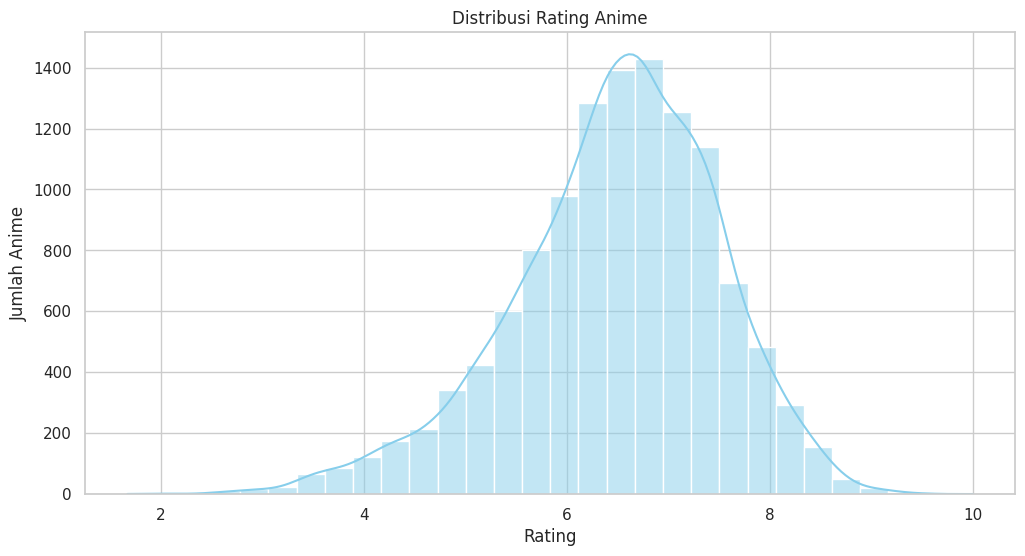

In [ ]:
sns.histplot(anime['rating'], bins=30, kde=True, color='skyblue')
plt.title("Distribusi Rating Anime")
plt.xlabel("Rating")
plt.ylabel("Jumlah Anime")
plt.show()

Hasil visualisasi distribusi rating anime menunjukkan bahwa mayoritas rating anime terdistribusi pada kisaran 5.8 hingga 7.5, dengan puncak pada sekitar rating 6.6 hingga 7.5. Ini menunjukkan bahwa sebagian besar anime mendapatkan rating yang cukup baik dari para pengguna. Selain itu, meskipun ada beberapa anime yang mendapatkan rating sangat rendah (di bawah 4) dan sangat tinggi (di atas 9), jumlah anime yang mendapatkan rating di kedua kategori tersebut relatif sedikit. Hal ini menunjukkan bahwa penonton cenderung memberikan rating pada anime dengan kualitas yang relatif layak, namun tidak terlalu ekstrem dalam memberikan penilaian baik atau buruk.

* Distribusi Jumlah Episode

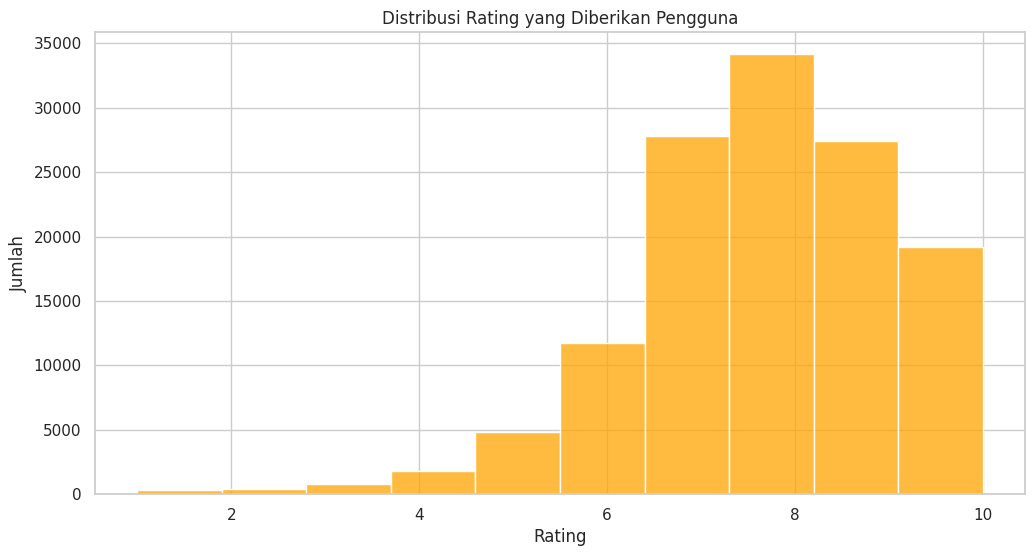

In [ ]:
sns.histplot(rating[rating['rating'] != -1]['rating'], bins=10, kde=False, color='orange')
plt.title("Distribusi Rating yang Diberikan Pengguna")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

Hasil visualisasi menunjukkan bahwa sebagian besar pengguna memberikan rating di kisaran 7 hingga 9, dengan puncak pada rating 8. Sangat sedikit pengguna yang memberikan rating rendah (1–3), menunjukkan bahwa pengguna cenderung hanya memberikan rating jika mereka menyukai anime tersebut. Rating 10 juga cukup sering muncul, menandakan adanya kemungkinan bias positif dalam penilaian.

* Jenis Anime Terpopuler

<ipython-input-16-021d002e5343>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=anime, y='type', order=anime['type'].value_counts().index, palette='viridis')


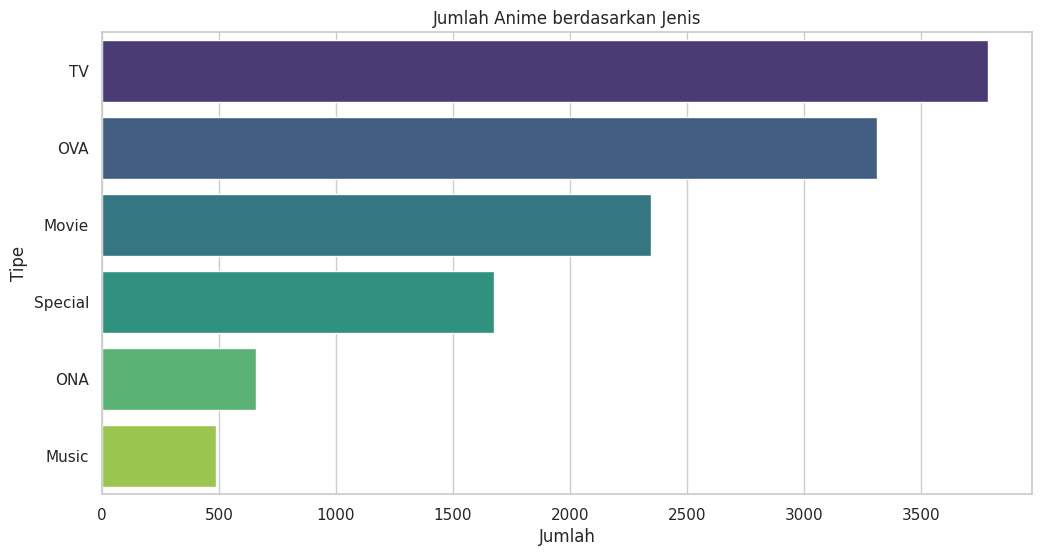

In [ ]:
sns.countplot(data=anime, y='type', order=anime['type'].value_counts().index, palette='viridis')
plt.title("Jumlah Anime berdasarkan Jenis")
plt.xlabel("Jumlah")
plt.ylabel("Tipe")
plt.show()

Hasil visualisasi menunjukkan bahwa jumlah anime terbanyak berasal dari jenis TV. Jenis anime ini mendominasi secara signifikan, yang mencerminkan preferensi pengguna untuk menonton serial TV dibandingkan dengan jenis anime lainnya.

Diikuti oleh OVA (Original Video Animation), yang menunjukkan bahwa anime yang hanya dirilis dalam format video sering kali juga mendapat perhatian yang cukup besar.

Movie mencatatkan 2348 anime, yang menandakan bahwa meskipun popularitasnya lebih rendah dibandingkan TV dan OVA, jenis anime ini tetap menjadi pilihan yang cukup populer bagi penonton.

Sedangkan Special dengan 1676 anime, menunjukkan bahwa anime yang dirilis sebagai episode khusus atau spin-off memiliki jumlah yang sedikit lebih rendah tetapi masih menjadi kategori yang cukup diminati.

Jenis ONA (Original Net Animation) memiliki jumlah yang lebih kecil, yaitu 659 anime, yang menunjukkan bahwa meskipun ada popularitas untuk anime yang dirilis langsung di platform streaming, jumlahnya masih lebih rendah dibandingkan dengan jenis lainnya.

Terakhir, Music mencatatkan 488 anime, yang paling sedikit di antara kategori lainnya.

<ipython-input-17-8e8e11cc5fa0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, y='Genre', x='Jumlah', palette='coolwarm')


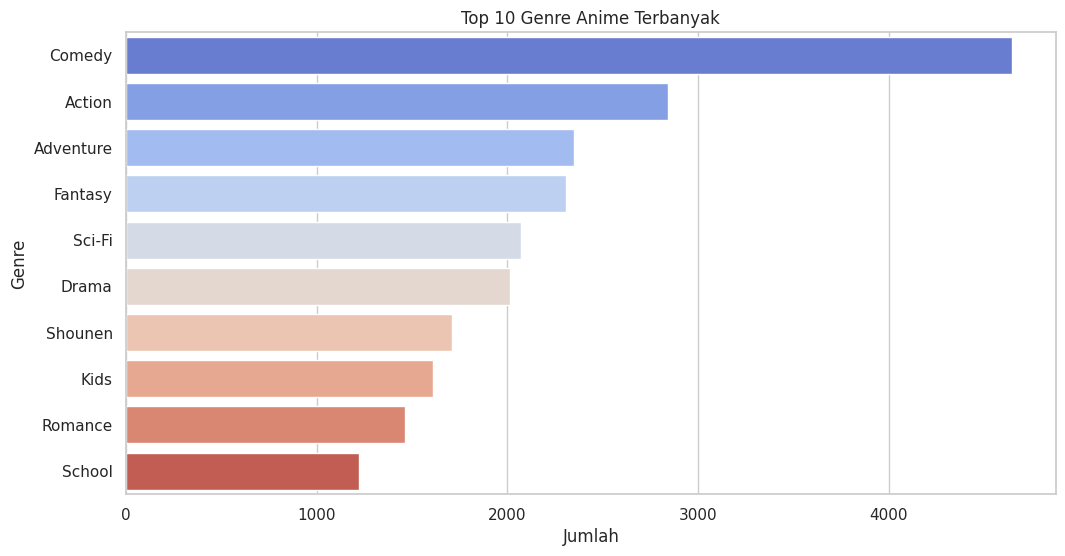

In [ ]:
genre_series = anime['genre'].dropna().str.split(', ')
genre_list = [genre for sublist in genre_series for genre in sublist]
genre_counts = Counter(genre_list)
top_genres = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Jumlah'])

sns.barplot(data=top_genres, y='Genre', x='Jumlah', palette='coolwarm')
plt.title("Top 10 Genre Anime Terbanyak")
plt.show()

Comedy adalah genre paling populer, diikuti oleh Action dan Adventure. Genre Fantasy dan Sci-Fi juga sangat diminati, sementara Drama mendapatkan perhatian yang cukup besar. Shounen dan Kids menunjukkan minat yang signifikan, meskipun sedikit lebih rendah. Romance dan School menempati posisi terakhir, namun tetap memiliki penggemar setia. Secara keseluruhan, genre komedi, aksi, dan petualangan mendominasi, dengan fantasi dan sains fiksi menjadi pilihan populer di kalangan penonton.

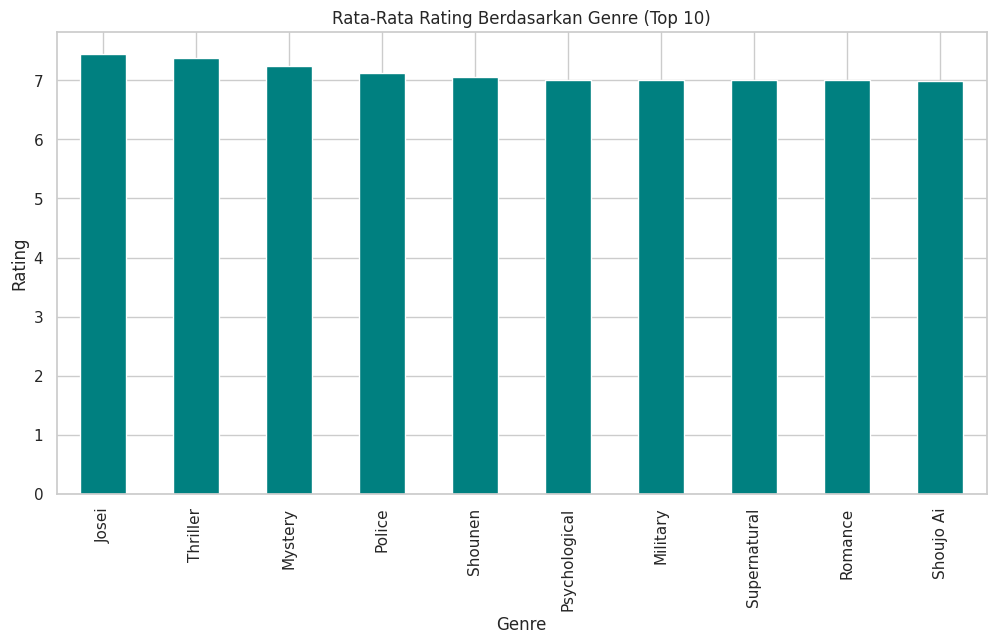

In [ ]:
genre_rating_df = []
for i, row in anime.dropna(subset=['genre', 'rating']).iterrows():
    genres = row['genre'].split(', ')
    for g in genres:
        genre_rating_df.append((g, row['rating']))

genre_rating_df = pd.DataFrame(genre_rating_df, columns=['Genre', 'Rating'])
top_genre_rating = genre_rating_df.groupby('Genre').mean().sort_values(by='Rating', ascending=False).head(10)

top_genre_rating.plot(kind='bar', color='teal', legend=False)
plt.title("Rata-Rata Rating Berdasarkan Genre (Top 10)")
plt.ylabel("Rating")
plt.show()

Josei mencatatkan rating tertinggi di antara genre lainnya, diikuti oleh Thriller dan Mystery, yang juga memiliki rating rata-rata yang cukup tinggi. Genre Police dan Shounen menduduki posisi berikutnya, dengan rating yang solid. Psychological dan Military menunjukkan rating yang cukup baik, sementara Supernatural dan Romance memiliki rating yang hampir serupa. Terakhir, Shoujo Ai mencatatkan rating rata-rata yang sedikit lebih rendah, tetapi tetap termasuk dalam 10 genre dengan rating tertinggi.

# Data Preprocessing
 Data Preprocessing adalah proses penting untuk menyiapkan data sebelum digunakan dalam pemodelan sistem rekomendasi.

In [ ]:
anime_refined = anime[anime['episodes'] != 'Unknown'].copy()
anime_refined['episodes'] = anime_refined['episodes'].astype(int)
anime_refined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11954 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  11954 non-null  int64  
 1   name      11954 non-null  object 
 2   genre     11903 non-null  object 
 3   type      11954 non-null  object 
 4   episodes  11954 non-null  int64  
 5   rating    11876 non-null  float64
 6   members   11954 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 747.1+ KB


In [ ]:
anime_refined.dropna(inplace=True)
anime_refined.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


In [ ]:
# Klasifikasi jumlah episode menjadi kategori
def episode_category(total):
    scale = 1818 // 10
    label = int((total - 1) // scale) + 1
    categories = [
        "very_short", "short", "moderate", "medium", "medium_long",
        "long", "very_long", "extra_long", "ultra_long", "epic"
    ]
    return categories[label - 1] if label <= 10 else "epic"

# Klasifikasi rating menjadi level kualitas
def rating_level(score):
    bins = [2, 3, 4, 5, 6, 7, 8, 9, 9.9]
    labels = [
        "terrible", "very_bad", "bad", "below_avg", "average",
        "above_avg", "good", "very_good", "excellent"
    ]
    for i, bound in enumerate(bins):
        if score < bound:
            return labels[i]
    return "masterpiece"

# Kategorisasi popularitas berdasarkan jumlah anggota
def popularity_segment(total_members):
    step = 100000
    labels = [
        "low", "moderate", "fair", "popular", "quite_popular",
        "very_popular", "high", "extremely", "super", "mega"
    ]
    idx = total_members // step
    return labels[min(idx, 9)]

# Menambahkan kolom kategori berdasarkan fitur
anime_refined['size_category'] = anime_refined['episodes'].apply(episode_category)
anime_refined['rating_category'] = anime_refined['rating'].apply(rating_level)
anime_refined['popularity_category'] = anime_refined['members'].apply(popularity_segment)

anime_refined['genre'] = anime_refined['genre'].apply(lambda x: ' '.join(x.split(', ')))

# Mengabungkan semua fitur menjadi satu kolom
anime_refined['combined_features'] = (
    anime_refined['genre'] + ' ' +
    anime_refined['type'] + ' ' +
    anime_refined['size_category'] + ' ' +
    anime_refined['rating_category'] + ' ' +
    anime_refined['popularity_category']
)

# Buang kolom yang tidak lagi digunakan
anime_model_data = anime_refined.drop(['episodes', 'rating', 'members'], axis=1).reset_index(drop=True)

In [ ]:
valid_ratings = rating[rating['rating'] >= 0].dropna().drop_duplicates().copy()
print(f"Sebelum dibersihkan: {len(rating)}")
print(f"Setelah dibersihkan: {len(valid_ratings)}")

Sebelum dibersihkan: 7813737
Setelah dibersihkan: 6337240


In [ ]:
anime.drop_duplicates(inplace=True)
rating.drop_duplicates(inplace=True)
print("Duplikat di anime setelah dibersihkan:", anime.duplicated().sum())
print("Duplikat di rating setelah dibersihkan:", rating.duplicated().sum())

Duplikat di anime setelah dibersihkan: 0
Duplikat di rating setelah dibersihkan: 0


In [ ]:
valid_ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [ ]:
user_map = {uid: idx for idx, uid in enumerate(valid_ratings['user_id'].unique())}
anime_map = {aid: idx for idx, aid in enumerate(valid_ratings['anime_id'].unique())}

valid_ratings['user_encoded'] = valid_ratings['user_id'].map(user_map)
valid_ratings['anime_encoded'] = valid_ratings['anime_id'].map(anime_map)

rmin, rmax = valid_ratings['rating'].min(), valid_ratings['rating'].max()
valid_ratings['normalized'] = valid_ratings['rating'].apply(lambda r: (r - rmin) / (rmax - rmin))

In [ ]:
X_matrix = valid_ratings[['user_encoded', 'anime_encoded']].values
y_vector = valid_ratings['normalized'].values

X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_vector, test_size=0.2, random_state=42)

# Model Deployment: Content-Based Filtering (CBF)

Content-Based Filtering (CBF) adalah metode dalam sistem rekomendasi yang merekomendasikan item (seperti anime, film, buku) berdasarkan kemiripan fitur konten dari anime yang pernah disukai atau dicari oleh pengguna. Pendekatan ini tidak bergantung pada interaksi pengguna lain, melainkan fokus pada karakteristik item itu sendiri.

Tahapan:
* Ekstrak fitur konten dari anime (genre, type, episode, rating, dsb)

* Gunakan teknik seperti TF-IDF, CountVectorizer, atau One-hot Encoding

* Hitung kemiripan antar anime dengan Cosine Similarity

* Rekomendasikan anime yang mirip dengan yang disukai pengguna

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(anime_model_data['combined_features'])

similarity_matrix = cosine_similarity(tfidf_matrix)

vectorizer.get_feature_names_out()

array(['above_avg', 'action', 'adventure', 'ai', 'arts', 'average', 'bad',
       'below_avg', 'cars', 'comedy', 'dementia', 'demons', 'drama',
       'ecchi', 'epic', 'excellent', 'extra_long', 'extremely', 'fair',
       'fantasy', 'fi', 'game', 'good', 'harem', 'hentai', 'high',
       'historical', 'horror', 'josei', 'kids', 'life', 'long', 'low',
       'magic', 'martial', 'masterpiece', 'mecha', 'medium',
       'medium_long', 'mega', 'military', 'moderate', 'movie', 'music',
       'mystery', 'ona', 'ova', 'parody', 'police', 'popular', 'power',
       'psychological', 'quite_popular', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'short', 'shoujo', 'shounen', 'slice', 'space',
       'special', 'sports', 'super', 'supernatural', 'terrible',
       'thriller', 'tv', 'ultra_long', 'vampire', 'very_bad', 'very_good',
       'very_popular', 'very_short', 'yaoi', 'yuri'], dtype=object)

Output diatas berisi daftar fitur atau kata yang dihasilkan oleh TfidfVectorizer selama pemrosesan teks pada kolom combined_features dalam dataset anime. Fitur-fitur ini merepresentasikan kata-kata atau kategori yang ditemukan dalam deskripsi anime seperti genre, rating, dan lainnya setelah diproses dengan teknik TF-IDF.

In [ ]:
def recommend_by_title(title_query, similarity_matrix=similarity_matrix, dataset=anime_model_data):
    try:
        index = dataset[dataset['name'] == title_query].index[0]
        scores = list(enumerate(similarity_matrix[index]))
        ranked_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        top_indices = [idx for idx, _ in ranked_scores[1:6]]
        results = dataset.iloc[top_indices][['name', 'genre', 'type', 'size_category', 'rating_category', 'popularity_category']].copy()
        results['similarity'] = [similarity_matrix[index][i] for i in top_indices]
        return results
    except:
        return "Anime title not found or invalid input."

sample_title = "Doraemon"
suggestions = recommend_by_title(sample_title)
print("Rekomendasi untuk:", sample_title + ":")
suggestions

Rekomendasi untuk: Doraemon:


,name,genre,type,size_category,rating_category,popularity_category,similarity
3329,TaoTao Ehonkan Sekai Doubutsu Banashi,Adventure Comedy Fantasy Kids,TV,very_short,good,low,0.906548
8666,Happy☆Lucky Bikkuriman,Adventure Comedy Fantasy Kids,TV,very_short,good,low,0.906548
994,Kekkaishi,Adventure Comedy Fantasy Shounen,TV,very_short,good,low,0.898993
989,Doraemon Movie 31: Shin Nobita to Tetsujin Hei...,Adventure Comedy Fantasy Kids Shounen,Movie,very_short,good,low,0.879014
1436,Doraemon Movie 28: Nobita to Midori no Kyojin Den,Adventure Comedy Fantasy Kids Shounen,Movie,very_short,good,low,0.879014


Output yang dihasilkan adalah daftar anime yang paling mirip dengan  anime Doraemon yang sesuai dengan judul yang diberikan. Kemiripan dihitung menggunakan cosine similarity, lalu hasilnya diurutkan dan ditampilkan 5 anime teratas beserta nilai kemiripan mereka. Jika judul anime tidak ditemukan atau input tidak valid, pesan kesalahan akan ditampilkan.

# Evaluasi Model CBF

Untuk mengevaluasi Sistem Rekomendasi dengan teknik Content-based Filtering (CBF) kita dapat menggunakan NDCG (Normalized Discounted Cumulative Gain).
NDCG dapat memberikan ukuran seberapa baik sistem mengurutkan dan merekomendasikan item anime yang relevan.

In [ ]:
def calculate_dcg(relevance_scores):
    positions = np.arange(1, len(relevance_scores) + 1)
    discounts = np.log2(positions + 1)
    dcg = np.sum(relevance_scores / discounts)
    return dcg

def calculate_idcg(relevance_scores):
    sorted_scores = np.sort(relevance_scores)[::-1]
    idcg = calculate_dcg(sorted_scores)
    return idcg

def calculate_ndcg(relevance_scores):
    dcg = calculate_dcg(relevance_scores)
    idcg = calculate_idcg(relevance_scores)
    ndcg = dcg / idcg if idcg != 0 else 0
    return ndcg

relevance_scores = [4, 4, 4, 4, 4]
ndcg = calculate_ndcg(relevance_scores)
print("NDCG Score:", ndcg)

NDCG Score: 1.0


Output diatas menunjukan bahwa sistem rekomendasi dengan pendeketan Content-Based Filtering (CBF) terlihat sangat baik, dengan NDCG score yang mencapai 1.0. Ini menunjukkan bahwa sistem telah mengurutkan item dengan sangat baik berdasarkan relevansi. Dalam konteks NDCG, nilai 1.0 adalah skor tertinggi yang berarti rekomendasi yang diberikan sepenuhnya relevan dan sesuai dengan urutan yang diinginkan oleh pengguna.

# Model Deployment & Evalution: Collaborative Filtering (CF)

Model Collaborative Filtering (CF) digunakan untuk memberikan rekomendasi berdasarkan interaksi antar pengguna dan item, dalam hal ini, anime. Cara kerjanya adalah dengan memanfaatkan data rating pengguna untuk memprediksi anime yang kemungkinan akan disukai oleh pengguna berdasarkan preferensi pengguna lain yang serupa.

In [ ]:
class RecommenderNet(Model):
    def __init__(self, num_users, num_animes, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = Embedding(num_users, embedding_size, embeddings_initializer="he_normal")
        self.anime_embedding = Embedding(num_animes, embedding_size, embeddings_initializer="he_normal")
        self.user_flat = Flatten()
        self.anime_flat = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        user_vector = self.user_flat(user_vector)
        anime_vector = self.anime_flat(anime_vector)
        return self.dot([user_vector, anime_vector])

In [ ]:
num_users = len(user_map)
num_animes = len(anime_map)

model = RecommenderNet(num_users, num_animes)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_split=0.2
)

Epoch 1/5
63373/63373 ━━━━━━━━━━━━━━━━━━━━ 2254s 36ms/step - loss: 0.1466 - mae: 0.2726 - val_loss: 0.0299 - val_mae: 0.1322
Epoch 2/5
63373/63373 ━━━━━━━━━━━━━━━━━━━━ 2206s 35ms/step - loss: 0.0258 - mae: 0.1238 - val_loss: 0.0273 - val_mae: 0.1262
Epoch 3/5
63373/63373 ━━━━━━━━━━━━━━━━━━━━ 2195s 35ms/step - loss: 0.0220 - mae: 0.1146 - val_loss: 0.0269 - val_mae: 0.1251
Epoch 4/5
63373/63373 ━━━━━━━━━━━━━━━━━━━━ 2248s 35ms/step - loss: 0.0202 - mae: 0.1100 - val_loss: 0.0270 - val_mae: 0.1250
Epoch 5/5
63373/63373 ━━━━━━━━━━━━━━━━━━━━ 2257s 35ms/step - loss: 0.0192 - mae: 0.1073 - val_loss: 0.0270 - val_mae: 0.1248


In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

39608/39608 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step
Mean Absolute Error (MAE): 0.1246
Root Mean Squared Error (RMSE): 0.1640


In [ ]:
# Pengguna yang ingin diberikan rekomendasi
target_user_id = 17440
encoded_user = user_map.get(target_user_id)

# Daftar anime yang sudah diberi rating oleh pengguna
rated_anime_ids = valid_ratings[valid_ratings['user_id'] == target_user_id]['anime_id'].tolist()
rated_encoded_ids = [anime_map[aid] for aid in rated_anime_ids if aid in anime_map]

# Kandidat rekomendasi anime yang belum pernah diberi rating
candidate_anime_ids = [idx for idx in range(num_animes) if idx not in rated_encoded_ids]
input_data = np.array([[encoded_user, aid] for aid in candidate_anime_ids])

predicted_ratings = model.predict(input_data).flatten()
top_indices = predicted_ratings.argsort()[-10:][::-1]

reverse_anime_map = {v: k for k, v in anime_map.items()}
recommended_anime_ids = [reverse_anime_map[candidate_anime_ids[i]] for i in top_indices]

recommended_titles = anime[anime['anime_id'].isin(recommended_anime_ids)][['anime_id', 'name','genre']]
print("Rekomendasi anime untuk user:", target_user_id)
recommended_titles

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Rekomendasi anime untuk user: 17440


,anime_id,name,genre
381,2762,Igano Kabamaru,"Adventure, Comedy, Romance, Shounen"
1256,22693,Lady Jewelpet,"Fantasy, Magic, Romance, Shoujo"
2098,30870,Ajin Part 3: Shougeki,"Action, Horror, Mystery, Seinen, Supernatural"
2337,1116,Junkers Come Here,"Drama, Slice of Life"
2776,751,Bomberman Jetters,"Action, Adventure, Comedy, Mystery, Sci-Fi, Sh..."
3315,1549,1000-nen Joou: Queen Millennia,"Adventure, Drama, Fantasy, Sci-Fi"
3907,30651,Itoshi no Muco,"Comedy, Slice of Life"
6655,17127,Chokkyuu Hyoudai Robot Anime: Straight Title,"Comedy, Mecha"
6827,2727,Sweet Valerian,"Action, Comedy, Magic, School, Shoujo"
7115,4150,Cosmos Pink Shock,"Comedy, Parody, Sci-Fi, Space"


Model telah berhasil memberikan rekomendasi anime yang sesuai dengan preferensi pengguna. Rekomendasi tersebut didasarkan pada anime yang sebelumnya telah diberi rating oleh pengguna, dan model ini juga memberikan skor prediksi untuk anime yang belum dinilai oleh pengguna tersebut.